Sources: We got the machine learning model that predicts income level of people in the 1994 US Census from this GitHub Repo: Adult-Census-Income/Adult Census Income.ipynb at master · pooja2512/Adult-Census-Income

## Introduction

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

Predict whether income exceeds $50K/yr based on census data.

Attribute Information:

1. **age**: continuous.
2. **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
3. **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
4. **education-num**: continuous.
5. **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
6. **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
7. **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
8. **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
9. **sex**: Female, Male.
10. **capital-gain: continuous.
11. capital-loss: continuous.
12. hours-per-week: continuous.
13. native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
14. **fnlwgt**: continuous.
 The weights on the CPS files are controlled to independent estimates of the
 civilian noninstitutional population of the US.  These are prepared monthly for us by Population Division here at the Census Bureau.  We use 3 sets of controls.
These are:
       1.  A single cell estimate of the population 16+ for each state.
       2.  Controls for Hispanic Origin by age and sex.
       3.  Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used.

The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population.
People with similar demographic characteristics should have similar weights.  There is one important caveat to remember about this statement.  That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

In [3]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
#% matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
adult_df = pd.read_csv('adult.csv')
print("Number of Observations in adult dataset:", adult_df.shape)

adult_df.head()

Number of Observations in adult dataset: (32561, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Preparing Data for ML Algorithms

In [5]:
print(f"Number of columns before deleting: {adult_df.shape[1]}")

del_cols = ['relationship','education.num']
adult_df.drop(labels = del_cols,axis = 1,inplace = True)
print(f"Number of columns after deleting: {adult_df.shape[1]}")

Number of columns before deleting: 15
Number of columns after deleting: 13


In [6]:
hrs_per_week = adult_df[adult_df['hours.per.week'] == 99]
print("Number of people working for 99 hours per week:", hrs_per_week.shape[0])


Number of people working for 99 hours per week: 85


In [7]:
# drop rows with age 90
print("Number of observation before removing:",adult_df.shape)
index_age = adult_df[adult_df['age'] == 90].index
adult_df.drop(labels = index_age,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df.shape)

Number of observation before removing: (32561, 13)
Number of observation after removing: (32518, 13)


In [8]:
print("Number of observation before removing:",adult_df.shape)
index_gain = adult_df[adult_df['capital.gain'] == 99999].index
adult_df.drop(labels = index_gain,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df.shape)

Number of observation before removing: (32518, 13)
Number of observation after removing: (32359, 13)


In [9]:
num_col_new = ['age','capital.gain', 'capital.loss',
       'hours.per.week','fnlwgt']
cat_col_new = ['workclass', 'education', 'marital.status', 'occupation',
               'race', 'sex', 'native.country', 'income']

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
pd.DataFrame(scaler.fit_transform(adult_df[num_col_new]),columns = num_col_new).head(3)

,age,capital.gain,capital.loss,hours.per.week,fnlwgt
0,0.915493,0.0,1.000000,0.173469,0.081896
1,0.690141,0.0,1.000000,0.397959,0.118021
2,0.521127,0.0,0.895317,0.397959,0.086982


In [11]:
class DataFrameSelector(TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        return X[self.attribute_names]


class num_trans(TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        df = pd.DataFrame(X)
        df.columns = num_col_new
        return df



pipeline = Pipeline([('selector',DataFrameSelector(num_col_new)),
                     ('scaler',MinMaxScaler()),
                    ('transform',num_trans())])



In [12]:
num_df = pipeline.fit_transform(adult_df)
num_df.shape

(32359, 5)

In [13]:
# columns which I don't need after creating dummy variables dataframe
cols = ['workclass_Govt_employess','education_Some-college',
        'marital.status_Never-married','occupation_Other-service',
        'race_Black','sex_Male','income_>50K']

In [14]:
class dummies(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        df = pd.get_dummies(X)
        df_new = df[df.columns.difference(cols)]
#difference returns the original columns, with the columns passed as argument removed.
        return df_new

pipeline_cat=Pipeline([('selector',DataFrameSelector(cat_col_new)),
                      ('dummies',dummies(cols))])
cat_df = pipeline_cat.fit_transform(adult_df)
cat_df.shape

(32359, 92)

In [15]:
cat_df['id'] = pd.Series(range(cat_df.shape[0]))
num_df['id'] = pd.Series(range(num_df.shape[0]))
final_df = pd.merge(cat_df,num_df,how = 'inner', on = 'id')
print(f"Number of observations in final dataset: {final_df.shape}")


Number of observations in final dataset: (32157, 98)


## Train and Fine Tuning on the model

In [16]:
y = final_df['income_<=50K']
final_df.drop(labels = ['id','income_<=50K'],axis = 1,inplace = True)
X = final_df

In [17]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc
from datetime import datetime
from sklearn.feature_selection import RFE

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.25,random_state = 42)
#Instantiate the classifiers
clf_logreg = LogisticRegression()
clf_tree = DecisionTreeClassifier()
clf_knn =  KNeighborsClassifier()
clf_gnb = GaussianNB()
classifiers = ['LogisticRegression', 'DecisionTree', 'KNN', 'SVC', 'Naive']
models = {clf_logreg:'LogisticRegression',
          clf_tree:'DecisionTree',
          clf_knn: 'KNN',
          clf_gnb: 'Naive'}
# train function fits the model and returns accuracy score
def train(algo,name,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    print(f"--------------------------------------------{name}---------------------------------------------------")
    print(f"Accuracy Score for {name}: {score*100:.4f}%")
    return y_test,y_pred,score

# acc_res function calculates confusion matrix
def acc_res(y_test,y_pred):
    null_accuracy = y_test.value_counts()[0]/len(y_test)
    print(f"Null Accuracy: {null_accuracy*100:.4f}%")
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,y_pred)
    print(matrix)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    accuracy_score=(TN+TP) / float(TP+TN+FP+FN)
    recall_score = (TP)/ float(TP+FN)
    specificity = TN / float(TN+FP)
    FPR = FP / float(FP+TN)
    precision_score = TP / float(TP+FP)
    print(f"Accuracy Score: {accuracy_score*100:.4f}%")
    print(f"Recall Score: {recall_score*100:.4f}%")
    print(f"Specificity Score: {specificity*100:.4f}%")
    print(f"False Positive Rate: {FPR*100:.4f}%")
    print(f"Precision Score: {precision_score*100:.4f}%")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Classification Report")
    print(classification_report(y_test,y_pred))

def main(models):
    accuracy_scores = []
    for algo,name in models.items():
        y_test_train,y_pred,acc_score = train(algo,name,X_train,y_train,X_test,y_test)
        acc_res(y_test_train,y_pred)
        accuracy_scores.append(acc_score)
    return accuracy_scores

accuracy_scores = main(models)


--------------------------------------------LogisticRegression---------------------------------------------------
Accuracy Score for LogisticRegression: 84.3781%
Null Accuracy: 76.5050%
Confusion Matrix
[[1061  828]
 [ 428 5723]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 84.3781%
Recall Score: 93.0418%
Specificity Score: 56.1673%
False Positive Rate: 43.8327%
Precision Score: 87.3607%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.71      0.56      0.63      1889
        True       0.87      0.93      0.90      6151

    accuracy                           0.84      8040
   macro avg       0.79      0.75      0.76      8040
weighted avg       0.84      0.84      0.84      8040



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2512564111.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------DecisionTree---------------------------------------------------
Accuracy Score for DecisionTree: 80.4851%
Null Accuracy: 76.5050%
Confusion Matrix
[[1102  787]
 [ 782 5369]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 80.4851%
Recall Score: 87.2866%
Specificity Score: 58.3377%
False Positive Rate: 41.6623%
Precision Score: 87.2157%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.58      0.58      0.58      1889
        True       0.87      0.87      0.87      6151

    accuracy                           0.80      8040
   macro avg       0.73      0.73      0.73      8040
weighted avg       0.80      0.80      0.80      8040



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2512564111.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------KNN---------------------------------------------------
Accuracy Score for KNN: 81.5920%
Null Accuracy: 76.5050%
Confusion Matrix
[[ 966  923]
 [ 557 5594]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 81.5920%
Recall Score: 90.9446%
Specificity Score: 51.1382%
False Positive Rate: 48.8618%
Precision Score: 85.8370%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.63      0.51      0.57      1889
        True       0.86      0.91      0.88      6151

    accuracy                           0.82      8040
   macro avg       0.75      0.71      0.72      8040
weighted avg       0.81      0.82      0.81      8040

--------------------------------------------Naive---------------------------------------------------
Accuracy Score for Naive: 36.9154%
Null Accuracy: 76.5050%
Confusi

/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2512564111.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)
/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2512564111.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


## Get the Data - Gaussian Noise: Normal Scale

In [18]:
import numpy as np
import pandas as pd

adult_df_gaussian = pd.read_csv('adult.csv')
print("Number of Observations in adult dataset:", adult_df.shape)

# Add Gaussian noise directly to the 'age' column
adult_df_gaussian['age'] += np.random.normal(loc=0, scale=10, size=adult_df_gaussian['age'].shape)

# Add Gaussian noise directly to the 'capital_gain' column
adult_df_gaussian['capital.gain'] += np.random.normal(loc=0, scale=1000, size=adult_df_gaussian['capital.gain'].shape)

# Add Gaussian noise directly to the 'hours_per_week' column
adult_df_gaussian['hours.per.week'] += np.random.normal(loc=0, scale=4, size=adult_df_gaussian['hours.per.week'].shape)

adult_df_gaussian.head()

Number of Observations in adult dataset: (32359, 13)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,89.737991,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,-4.938454,4356,42.665837,United-States,<=50K
1,83.550235,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,-851.525204,4356,21.807815,United-States,<=50K
2,64.160518,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,-155.126724,4356,40.866870,United-States,<=50K
3,54.714592,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,1022.379164,3900,37.380598,United-States,<=50K
4,12.692263,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,974.496122,3900,39.858103,United-States,<=50K


## Preparing Data for ML Algorithms - Gaussian Noise Normal Scale

In [19]:
# Delete columns
del_cols_gaussian = ['relationship','education.num']
adult_df_gaussian.drop(labels = del_cols,axis = 1,inplace = True)

hrs_per_week_gaussian = adult_df_gaussian[adult_df_gaussian['hours.per.week'] == 99]

# drop rows with age 90
print("Number of observation before removing:",adult_df_gaussian.shape)
index_age_gaussian = adult_df_gaussian[adult_df_gaussian['age'] == 90].index
adult_df_gaussian.drop(labels = index_age_gaussian,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_gaussian.shape)

print("Number of observation before removing:",adult_df_gaussian.shape)
index_gain_gaussian = adult_df_gaussian[adult_df_gaussian['capital.gain'] == 99999].index
adult_df_gaussian.drop(labels = index_gain_gaussian,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_gaussian.shape)

num_col_new_gaussian = ['age','capital.gain', 'capital.loss',
       'hours.per.week','fnlwgt']
cat_col_new_gaussian = ['workclass', 'education', 'marital.status', 'occupation',
               'race', 'sex', 'native.country', 'income']

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler_gaussian = MinMaxScaler()
pd.DataFrame(scaler_gaussian.fit_transform(adult_df_gaussian[num_col_new_gaussian]),columns = num_col_new_gaussian).head(3)

class DataFrameSelector(TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        return X[self.attribute_names]


class num_trans(TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        df = pd.DataFrame(X)
        df.columns = num_col_new
        return df



pipeline_gaussian = Pipeline([('selector',DataFrameSelector(num_col_new)),
                     ('scaler',MinMaxScaler()),
                    ('transform',num_trans())])

num_df_gaussian = pipeline_gaussian.fit_transform(adult_df_gaussian)
num_df_gaussian.shape

# columns which I don't need after creating dummy variables dataframe
cols_gaussian = ['workclass_Govt_employess','education_Some-college',
        'marital.status_Never-married','occupation_Other-service',
        'race_Black','sex_Male','income_>50K']

class dummies(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols_gaussian

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        df_gaussian = pd.get_dummies(X)
        df_new_gaussian = df_gaussian[df_gaussian.columns.difference(cols)]
#difference returns the original columns, with the columns passed as argument removed.
        return df_new_gaussian

pipeline_cat_gaussian=Pipeline([('selector',DataFrameSelector(cat_col_new)),
                      ('dummies',dummies(cols))])
cat_df_gaussian = pipeline_cat_gaussian.fit_transform(adult_df_gaussian)
cat_df_gaussian.shape

cat_df_gaussian['id'] = pd.Series(range(cat_df_gaussian.shape[0]))
num_df_gaussian['id'] = pd.Series(range(num_df_gaussian.shape[0]))

final_df_gaussian = pd.merge(cat_df_gaussian,num_df_gaussian,how = 'inner', on = 'id')
print(f"Number of observations in final dataset: {final_df_gaussian.shape}")

Number of observation before removing: (32561, 13)
Number of observation after removing: (32561, 13)
Number of observation before removing: (32561, 13)
Number of observation after removing: (32561, 13)
Number of observations in final dataset: (32561, 98)


## Train and Fine Tuning on the model - Gaussian Noise Normal Scale

In [20]:
y = final_df_gaussian['income_<=50K']
final_df_gaussian.drop(labels = ['id','income_<=50K'],axis = 1,inplace = True)
X = final_df_gaussian

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc
from datetime import datetime
from sklearn.feature_selection import RFE

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.25,random_state = 42)

#Instantiate the classifiers
clf_logreg = LogisticRegression()
clf_tree = DecisionTreeClassifier()
clf_knn =  KNeighborsClassifier()
clf_gnb = GaussianNB()

classifiers = ['LogisticRegression', 'DecisionTree', 'KNN', 'SVC', 'Naive']

models = {clf_logreg:'LogisticRegression',
          clf_tree:'DecisionTree',
          clf_knn: 'KNN',
          clf_gnb: 'Naive'}

# train function fits the model and returns accuracy score
def train(algo,name,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    print(f"--------------------------------------------{name}---------------------------------------------------")
    print(f"Accuracy Score for {name}: {score*100:.4f}%")
    return y_test,y_pred,score

# acc_res function calculates confusion matrix
def acc_res(y_test,y_pred):
    null_accuracy = y_test.value_counts()[0]/len(y_test)
    print(f"Null Accuracy: {null_accuracy*100:.4f}%")
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,y_pred)
    print(matrix)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    accuracy_score=(TN+TP) / float(TP+TN+FP+FN)
    recall_score = (TP)/ float(TP+FN)
    specificity = TN / float(TN+FP)
    FPR = FP / float(FP+TN)
    precision_score = TP / float(TP+FP)
    print(f"Accuracy Score: {accuracy_score*100:.4f}%")
    print(f"Recall Score: {recall_score*100:.4f}%")
    print(f"Specificity Score: {specificity*100:.4f}%")
    print(f"False Positive Rate: {FPR*100:.4f}%")
    print(f"Precision Score: {precision_score*100:.4f}%")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Classification Report")
    print(classification_report(y_test,y_pred))

def main(models):
    accuracy_scores = []
    for algo,name in models.items():
        y_test_train,y_pred,acc_score = train(algo,name,X_train,y_train,X_test,y_test)
        acc_res(y_test_train,y_pred)
        accuracy_scores.append(acc_score)
    return accuracy_scores

accuracy_scores = main(models)

--------------------------------------------LogisticRegression---------------------------------------------------
Accuracy Score for LogisticRegression: 84.1666%
Null Accuracy: 76.1209%
Confusion Matrix
[[1080  864]
 [ 425 5772]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 84.1666%
Recall Score: 93.1418%
Specificity Score: 55.5556%
False Positive Rate: 44.4444%
Precision Score: 86.9801%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.72      0.56      0.63      1944
        True       0.87      0.93      0.90      6197

    accuracy                           0.84      8141
   macro avg       0.79      0.74      0.76      8141
weighted avg       0.83      0.84      0.83      8141



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/1999007911.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------DecisionTree---------------------------------------------------
Accuracy Score for DecisionTree: 79.8551%
Null Accuracy: 76.1209%
Confusion Matrix
[[1146  798]
 [ 842 5355]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 79.8551%
Recall Score: 86.4128%
Specificity Score: 58.9506%
False Positive Rate: 41.0494%
Precision Score: 87.0307%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.58      0.59      0.58      1944
        True       0.87      0.86      0.87      6197

    accuracy                           0.80      8141
   macro avg       0.72      0.73      0.73      8141
weighted avg       0.80      0.80      0.80      8141



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/1999007911.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------KNN---------------------------------------------------
Accuracy Score for KNN: 81.0834%
Null Accuracy: 76.1209%
Confusion Matrix
[[1016  928]
 [ 612 5585]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 81.0834%
Recall Score: 90.1243%
Specificity Score: 52.2634%
False Positive Rate: 47.7366%
Precision Score: 85.7516%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.62      0.52      0.57      1944
        True       0.86      0.90      0.88      6197

    accuracy                           0.81      8141
   macro avg       0.74      0.71      0.72      8141
weighted avg       0.80      0.81      0.80      8141

--------------------------------------------Naive---------------------------------------------------
Accuracy Score for Naive: 35.0571%
Null Accuracy: 76.1209%
Confusi

/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/1999007911.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)
/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/1999007911.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


## Reidentification on Gaussian Noise Normal Scale

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances_argmin_min

adult_df_original = pd.read_csv('adult.csv')

adult_df_normal_noise = adult_df_original.copy()

np.random.seed(42)  # for reproducibility
adult_df_normal_noise['age'] += np.random.normal(loc=0, scale=10, size=adult_df_normal_noise['age'].shape)
adult_df_normal_noise['capital.gain'] += np.random.normal(loc=0, scale=1000, size=adult_df_normal_noise['capital.gain'].shape)
adult_df_normal_noise['hours.per.week'] += np.random.normal(loc=0, scale=4, size=adult_df_normal_noise['hours.per.week'].shape)

cols_to_compare = ['age', 'capital.gain', 'hours.per.week']

def normalize(df, cols):
    return (df[cols] - df[cols].mean()) / df[cols].std()

original_normalized = normalize(adult_df_original, cols_to_compare)
normal_noise_normalized = normalize(adult_df_normal_noise, cols_to_compare)

indices, distances = pairwise_distances_argmin_min(normal_noise_normalized, original_normalized)

correct_matches = sum(np.arange(len(adult_df_original)) == indices)
reidentification_rate = correct_matches / len(adult_df_original)

print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

results_df = pd.DataFrame({
    'Original_Index': np.arange(len(adult_df_original)),
    'Matched_Index': indices,
    'Distance': distances,
    'Correctly_Matched': np.arange(len(adult_df_original)) == indices
})

print("\nDistance Statistics:")
print(f"Mean Distance: {np.mean(distances):.4f}")
print(f"Median Distance: {np.median(distances):.4f}")
print(f"Min Distance: {np.min(distances):.4f}")
print(f"Max Distance: {np.max(distances):.4f}")

print("\nCorrect Matches:", correct_matches)
print("Total Records:", len(adult_df_original))
print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

Re-identification Rate: 0.39%

Distance Statistics:
Mean Distance: 0.1254
Median Distance: 0.1027
Min Distance: 0.0025
Max Distance: 1.6605

Correct Matches: 126
Total Records: 32561
Re-identification Rate: 0.39%


## Get the Data - Gaussian Noise: Scale Doubled

In [22]:
import numpy as np
import pandas as pd

adult_df_gaussian_num_doubled = pd.read_csv('adult.csv')
print("Number of Observations in adult dataset:", adult_df_gaussian_num_doubled.shape)

# Add Gaussian noise directly to the 'age' column
adult_df_gaussian_num_doubled['age'] += np.random.normal(loc=0, scale=20, size=adult_df_gaussian_num_doubled['age'].shape)

# Add Gaussian noise directly to the 'capital_gain' column
adult_df_gaussian_num_doubled['capital.gain'] += np.random.normal(loc=0, scale=2000, size=adult_df_gaussian_num_doubled['capital.gain'].shape)

# Add Gaussian noise directly to the 'hours_per_week' column
adult_df_gaussian_num_doubled['hours.per.week'] += np.random.normal(loc=0, scale=8, size=adult_df_gaussian_num_doubled['hours.per.week'].shape)

adult_df_gaussian_num_doubled.head()

Number of Observations in adult dataset: (32561, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,64.173122,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,865.542146,4356,35.074889,United-States,<=50K
1,81.565386,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,-1963.501084,4356,9.481541,United-States,<=50K
2,65.912930,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,-512.760016,4356,39.373534,United-States,<=50K
3,59.142174,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,-1788.203212,3900,37.662230,United-States,<=50K
4,12.116003,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,-107.309137,3900,38.990266,United-States,<=50K


## Preparing Data for ML Algorithms - Gaussian Noise Scale Doubled

In [23]:
hrs_per_week_gaussian_num_doubled = adult_df_gaussian_num_doubled[adult_df_gaussian_num_doubled['hours.per.week'] == 99]

# drop rows with age 90
print("Number of observation before removing:",adult_df_gaussian_num_doubled.shape)
index_age_gaussian_num_doubled = adult_df_gaussian_num_doubled[adult_df_gaussian_num_doubled['age'] == 90].index
adult_df_gaussian_num_doubled.drop(labels = index_age_gaussian_num_doubled,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_gaussian_num_doubled.shape)

print("Number of observation before removing:",adult_df_gaussian_num_doubled.shape)
index_gain_gaussian_num_doubled = adult_df_gaussian_num_doubled[adult_df_gaussian_num_doubled['capital.gain'] == 99999].index
adult_df_gaussian_num_doubled.drop(labels = index_gain_gaussian_num_doubled,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_gaussian_num_doubled.shape)

num_col_new_gaussian_num_doubled = ['age','capital.gain', 'capital.loss',
       'hours.per.week','fnlwgt']
cat_col_new_gaussian_num_doubled = ['workclass', 'education', 'marital.status', 'occupation',
               'race', 'sex', 'native.country', 'income']

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler_gaussian_num_doubled = MinMaxScaler()
pd.DataFrame(scaler_gaussian_num_doubled.fit_transform(adult_df_gaussian_num_doubled[num_col_new_gaussian_num_doubled]),columns = num_col_new_gaussian_num_doubled).head(3)

class DataFrameSelector(TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        return X[self.attribute_names]


class num_trans(TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        df = pd.DataFrame(X)
        df.columns = num_col_new_gaussian_num_doubled
        return df



pipeline_gaussian_num_doubled = Pipeline([('selector',DataFrameSelector(num_col_new_gaussian_num_doubled)),
                     ('scaler',MinMaxScaler()),
                    ('transform',num_trans())])

num_df_gaussian_num_doubled = pipeline_gaussian_num_doubled.fit_transform(adult_df_gaussian_num_doubled)
num_df_gaussian_num_doubled.shape

# columns which I don't need after creating dummy variables dataframe
cols_gaussian_num_doubled = ['workclass_Govt_employess','education_Some-college',
        'marital.status_Never-married','occupation_Other-service',
        'race_Black','sex_Male','income_>50K']

class dummies(TransformerMixin):
    def __init__(self, cols):
        self.cols = cols  # Store the passed columns to self.cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df_gaussian_num_doubled = pd.get_dummies(X)
        # Use self.cols instead of undefined cols
        df_new_gaussian_num_doubled = df_gaussian_num_doubled[df_gaussian_num_doubled.columns.difference(self.cols)]
        return df_new_gaussian_num_doubled


pipeline_cat_gaussian_num_doubled = Pipeline([
    ('selector', DataFrameSelector(cat_col_new_gaussian_num_doubled)),  # Make sure cat_col_new_gaussian_num_doubled is defined
    ('dummies', dummies(cols_gaussian_num_doubled))  # Pass the actual column list here
])

cat_df_gaussian_num_doubled = pipeline_cat_gaussian_num_doubled.fit_transform(adult_df_gaussian_num_doubled)
cat_df_gaussian_num_doubled.shape

cat_df_gaussian_num_doubled['id'] = pd.Series(range(cat_df_gaussian_num_doubled.shape[0]))
num_df_gaussian_num_doubled['id'] = pd.Series(range(num_df_gaussian_num_doubled.shape[0]))

final_df_gaussian_num_doubled = pd.merge(cat_df_gaussian_num_doubled,num_df_gaussian_num_doubled,how = 'inner', on = 'id')
print(f"Number of observations in final dataset: {final_df_gaussian_num_doubled.shape}")

Number of observation before removing: (32561, 15)
Number of observation after removing: (32561, 15)
Number of observation before removing: (32561, 15)
Number of observation after removing: (32561, 15)
Number of observations in final dataset: (32561, 98)


## Train and Fine Tuning on the model - Gaussian Noise Scale Doubled

In [24]:
y = final_df_gaussian_num_doubled['income_<=50K']
final_df_gaussian_num_doubled.drop(labels = ['id','income_<=50K'],axis = 1,inplace = True)
X = final_df_gaussian_num_doubled

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc
from datetime import datetime
from sklearn.feature_selection import RFE

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.25,random_state = 42)

#Instantiate the classifiers
clf_logreg = LogisticRegression()
clf_tree = DecisionTreeClassifier()
clf_knn =  KNeighborsClassifier()
clf_gnb = GaussianNB()

classifiers = ['LogisticRegression', 'DecisionTree', 'KNN', 'SVC', 'Naive']

models = {clf_logreg:'LogisticRegression',
          clf_tree:'DecisionTree',
          clf_knn: 'KNN',
          clf_gnb: 'Naive'}

# train function fits the model and returns accuracy score
def train(algo,name,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    print(f"--------------------------------------------{name}---------------------------------------------------")
    print(f"Accuracy Score for {name}: {score*100:.4f}%")
    return y_test,y_pred,score

# acc_res function calculates confusion matrix
def acc_res(y_test,y_pred):
    null_accuracy = y_test.value_counts()[0]/len(y_test)
    print(f"Null Accuracy: {null_accuracy*100:.4f}%")
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,y_pred)
    print(matrix)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    accuracy_score=(TN+TP) / float(TP+TN+FP+FN)
    recall_score = (TP)/ float(TP+FN)
    specificity = TN / float(TN+FP)
    FPR = FP / float(FP+TN)
    precision_score = TP / float(TP+FP)
    print(f"Accuracy Score: {accuracy_score*100:.4f}%")
    print(f"Recall Score: {recall_score*100:.4f}%")
    print(f"Specificity Score: {specificity*100:.4f}%")
    print(f"False Positive Rate: {FPR*100:.4f}%")
    print(f"Precision Score: {precision_score*100:.4f}%")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Classification Report")
    print(classification_report(y_test,y_pred))

def main(models):
    accuracy_scores = []
    for algo,name in models.items():
        y_test_train,y_pred,acc_score = train(algo,name,X_train,y_train,X_test,y_test)
        acc_res(y_test_train,y_pred)
        accuracy_scores.append(acc_score)
    return accuracy_scores

accuracy_scores = main(models)

--------------------------------------------LogisticRegression---------------------------------------------------
Accuracy Score for LogisticRegression: 83.8226%
Null Accuracy: 76.1209%
Confusion Matrix
[[1052  892]
 [ 425 5772]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 83.8226%
Recall Score: 93.1418%
Specificity Score: 54.1152%
False Positive Rate: 45.8848%
Precision Score: 86.6146%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.71      0.54      0.62      1944
        True       0.87      0.93      0.90      6197

    accuracy                           0.84      8141
   macro avg       0.79      0.74      0.76      8141
weighted avg       0.83      0.84      0.83      8141



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2095576094.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------DecisionTree---------------------------------------------------
Accuracy Score for DecisionTree: 79.3760%
Null Accuracy: 76.1209%
Confusion Matrix
[[1104  840]
 [ 839 5358]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 79.3760%
Recall Score: 86.4612%
Specificity Score: 56.7901%
False Positive Rate: 43.2099%
Precision Score: 86.4472%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.57      0.57      0.57      1944
        True       0.86      0.86      0.86      6197

    accuracy                           0.79      8141
   macro avg       0.72      0.72      0.72      8141
weighted avg       0.79      0.79      0.79      8141



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2095576094.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------KNN---------------------------------------------------
Accuracy Score for KNN: 81.1080%
Null Accuracy: 76.1209%
Confusion Matrix
[[ 995  949]
 [ 589 5608]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 81.1080%
Recall Score: 90.4954%
Specificity Score: 51.1831%
False Positive Rate: 48.8169%
Precision Score: 85.5269%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.63      0.51      0.56      1944
        True       0.86      0.90      0.88      6197

    accuracy                           0.81      8141
   macro avg       0.74      0.71      0.72      8141
weighted avg       0.80      0.81      0.80      8141

--------------------------------------------Naive---------------------------------------------------
Accuracy Score for Naive: 34.9097%
Null Accuracy: 76.1209%
Confusi

/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2095576094.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)
/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2095576094.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


## Reidentification on Gaussian Noise Double Scale

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances_argmin_min

adult_df_original = pd.read_csv('adult.csv')

adult_df_double_noise = adult_df_original.copy()


np.random.seed(42)
adult_df_double_noise['age'] += np.random.normal(loc=0, scale=20, size=adult_df_double_noise['age'].shape)
adult_df_double_noise['capital.gain'] += np.random.normal(loc=0, scale=2000, size=adult_df_double_noise['capital.gain'].shape)
adult_df_double_noise['hours.per.week'] += np.random.normal(loc=0, scale=8, size=adult_df_double_noise['hours.per.week'].shape)

cols_to_compare = ['age', 'capital.gain', 'hours.per.week']

def normalize(df, cols):
    return (df[cols] - df[cols].mean()) / df[cols].std()

original_normalized = normalize(adult_df_original, cols_to_compare)
double_noise_normalized = normalize(adult_df_double_noise, cols_to_compare)

indices, distances = pairwise_distances_argmin_min(double_noise_normalized, original_normalized)

correct_matches = sum(np.arange(len(adult_df_original)) == indices)
reidentification_rate = correct_matches / len(adult_df_original)

print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

results_df = pd.DataFrame({
    'Original_Index': np.arange(len(adult_df_original)),
    'Matched_Index': indices,
    'Distance': distances,
    'Correctly_Matched': np.arange(len(adult_df_original)) == indices
})

print("\nDistance Statistics:")
print(f"Mean Distance: {np.mean(distances):.4f}")
print(f"Median Distance: {np.median(distances):.4f}")
print(f"Min Distance: {np.min(distances):.4f}")
print(f"Max Distance: {np.max(distances):.4f}")

print("\nCorrect Matches:", correct_matches)
print("Total Records:", len(adult_df_original))
print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

Re-identification Rate: 0.13%

Distance Statistics:
Mean Distance: 0.1894
Median Distance: 0.1422
Min Distance: 0.0034
Max Distance: 2.2652

Correct Matches: 42
Total Records: 32561
Re-identification Rate: 0.13%


## Get the Data - Gaussian Noise: Triple Scale

In [26]:
import numpy as np
import pandas as pd

adult_df_gaussian_num_triple = pd.read_csv('adult.csv')
print("Number of Observations in adult dataset:", adult_df_gaussian.shape)

# Add Gaussian noise directly to the 'age' column
adult_df_gaussian_num_triple['age'] += np.random.normal(loc=0, scale=30, size=adult_df_gaussian_num_triple['age'].shape)

# Add Gaussian noise directly to the 'capital_gain' column
adult_df_gaussian_num_triple['capital.gain'] += np.random.normal(loc=0, scale=3000, size=adult_df_gaussian_num_triple['capital.gain'].shape)

# Add Gaussian noise directly to the 'hours_per_week' column
adult_df_gaussian_num_triple['hours.per.week'] += np.random.normal(loc=0, scale=12, size=adult_df_gaussian_num_triple['hours.per.week'].shape)

adult_df_gaussian_num_triple.head()

Number of Observations in adult dataset: (32561, 13)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,51.259684,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,1298.313219,4356,32.612334,United-States,<=50K
1,81.348078,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,-2945.251625,4356,5.222311,United-States,<=50K
2,65.869395,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,-769.140024,4356,39.060300,United-States,<=50K
3,61.713261,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,-2682.304819,3900,36.493345,United-States,<=50K
4,-2.325995,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,-160.963705,3900,38.485399,United-States,<=50K


## Preparing Data for ML Algorithms - Gaussian Noise Triple Scale

In [27]:
hrs_per_week_gaussian_num_triple = adult_df_gaussian_num_triple[adult_df_gaussian_num_triple['hours.per.week'] == 99]

# drop rows with age 90
print("Number of observation before removing:",adult_df_gaussian_num_triple.shape)
index_age_gaussian_num_triple = adult_df_gaussian_num_triple[adult_df_gaussian_num_triple['age'] == 90].index
adult_df_gaussian_num_triple.drop(labels = index_age_gaussian_num_triple,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_gaussian_num_triple.shape)

print("Number of observation before removing:",adult_df_gaussian_num_triple.shape)
index_gain_gaussian_num_triple = adult_df_gaussian_num_triple[adult_df_gaussian_num_triple['capital.gain'] == 99999].index
adult_df_gaussian_num_triple.drop(labels = index_gain_gaussian_num_triple,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_gaussian_num_triple.shape)

num_col_new_gaussian_num_triple = ['age','capital.gain', 'capital.loss',
       'hours.per.week','fnlwgt']
cat_col_new_gaussian_num_triple = ['workclass', 'education', 'marital.status', 'occupation',
               'race', 'sex', 'native.country', 'income']

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler_gaussian_num_triple = MinMaxScaler()
pd.DataFrame(scaler_gaussian_num_triple.fit_transform(adult_df_gaussian_num_triple[num_col_new_gaussian_num_triple]),columns = num_col_new_gaussian_num_triple).head(3)

class DataFrameSelector(TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        return X[self.attribute_names]


class num_trans(TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        df = pd.DataFrame(X)
        df.columns = num_col_new_gaussian_num_triple
        return df



pipeline_gaussian_num_triple = Pipeline([('selector',DataFrameSelector(num_col_new_gaussian_num_triple)),
                     ('scaler',MinMaxScaler()),
                    ('transform',num_trans())])

num_df_gaussian_num_triple = pipeline_gaussian_num_triple.fit_transform(adult_df_gaussian_num_triple)
num_df_gaussian_num_triple.shape

# columns which I don't need after creating dummy variables dataframe
cols_gaussian_num_triple = ['workclass_Govt_employess','education_Some-college',
        'marital.status_Never-married','occupation_Other-service',
        'race_Black','sex_Male','income_>50K']

class dummies(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols_gaussian_num_triple

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        df_gaussian_num_triple = pd.get_dummies(X)
        df_new_gaussian_num_triple = df_gaussian_num_triple[df_gaussian_num_triple.columns.difference(cols)]
#difference returns the original columns, with the columns passed as argument removed.
        return df_new_gaussian_num_triple

pipeline_cat_gaussian_num_triple=Pipeline([('selector',DataFrameSelector(cat_col_new_gaussian_num_triple)),
                      ('dummies',dummies(cols))])
cat_df_gaussian_num_triple = pipeline_cat_gaussian_num_triple.fit_transform(adult_df_gaussian_num_triple)
cat_df_gaussian_num_triple.shape

cat_df_gaussian_num_triple['id'] = pd.Series(range(cat_df_gaussian_num_triple.shape[0]))
num_df_gaussian_num_triple['id'] = pd.Series(range(num_df_gaussian_num_triple.shape[0]))

final_df_gaussian_num_triple = pd.merge(cat_df_gaussian_num_triple,num_df_gaussian_num_triple,how = 'inner', on = 'id')
print(f"Number of observations in final dataset: {final_df_gaussian_num_triple.shape}")

Number of observation before removing: (32561, 15)
Number of observation after removing: (32561, 15)
Number of observation before removing: (32561, 15)
Number of observation after removing: (32561, 15)
Number of observations in final dataset: (32561, 98)


## Train and Fine Tuning on the model - Gaussian Noise Triple Scale

In [28]:
y = final_df_gaussian_num_triple['income_<=50K']
final_df_gaussian_num_triple.drop(labels = ['id','income_<=50K'],axis = 1,inplace = True)
X = final_df_gaussian_num_triple

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc
from datetime import datetime
from sklearn.feature_selection import RFE

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.25,random_state = 42)

#Instantiate the classifiers
clf_logreg = LogisticRegression()
clf_tree = DecisionTreeClassifier()
clf_knn =  KNeighborsClassifier()
clf_gnb = GaussianNB()

classifiers = ['LogisticRegression', 'DecisionTree', 'KNN', 'SVC', 'Naive']

models = {clf_logreg:'LogisticRegression',
          clf_tree:'DecisionTree',
          clf_knn: 'KNN',
          clf_gnb: 'Naive'}

# train function fits the model and returns accuracy score
def train(algo,name,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    print(f"--------------------------------------------{name}---------------------------------------------------")
    print(f"Accuracy Score for {name}: {score*100:.4f}%")
    return y_test,y_pred,score

# acc_res function calculates confusion matrix
def acc_res(y_test,y_pred):
    null_accuracy = y_test.value_counts()[0]/len(y_test)
    print(f"Null Accuracy: {null_accuracy*100:.4f}%")
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,y_pred)
    print(matrix)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    accuracy_score=(TN+TP) / float(TP+TN+FP+FN)
    recall_score = (TP)/ float(TP+FN)
    specificity = TN / float(TN+FP)
    FPR = FP / float(FP+TN)
    precision_score = TP / float(TP+FP)
    print(f"Accuracy Score: {accuracy_score*100:.4f}%")
    print(f"Recall Score: {recall_score*100:.4f}%")
    print(f"Specificity Score: {specificity*100:.4f}%")
    print(f"False Positive Rate: {FPR*100:.4f}%")
    print(f"Precision Score: {precision_score*100:.4f}%")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Classification Report")
    print(classification_report(y_test,y_pred))

def main(models):
    accuracy_scores = []
    for algo,name in models.items():
        y_test_train,y_pred,acc_score = train(algo,name,X_train,y_train,X_test,y_test)
        acc_res(y_test_train,y_pred)
        accuracy_scores.append(acc_score)
    return accuracy_scores

accuracy_scores = main(models)

--------------------------------------------LogisticRegression---------------------------------------------------
Accuracy Score for LogisticRegression: 83.4787%
Null Accuracy: 76.1209%
Confusion Matrix
[[1035  909]
 [ 436 5761]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 83.4787%
Recall Score: 92.9643%
Specificity Score: 53.2407%
False Positive Rate: 46.7593%
Precision Score: 86.3718%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.70      0.53      0.61      1944
        True       0.86      0.93      0.90      6197

    accuracy                           0.83      8141
   macro avg       0.78      0.73      0.75      8141
weighted avg       0.83      0.83      0.83      8141



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2653346923.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------DecisionTree---------------------------------------------------
Accuracy Score for DecisionTree: 78.8847%
Null Accuracy: 76.1209%
Confusion Matrix
[[1079  865]
 [ 854 5343]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 78.8847%
Recall Score: 86.2191%
Specificity Score: 55.5041%
False Positive Rate: 44.4959%
Precision Score: 86.0664%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.56      0.56      0.56      1944
        True       0.86      0.86      0.86      6197

    accuracy                           0.79      8141
   macro avg       0.71      0.71      0.71      8141
weighted avg       0.79      0.79      0.79      8141



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2653346923.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------KNN---------------------------------------------------
Accuracy Score for KNN: 80.7640%
Null Accuracy: 76.1209%
Confusion Matrix
[[ 999  945]
 [ 621 5576]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 80.7640%
Recall Score: 89.9790%
Specificity Score: 51.3889%
False Positive Rate: 48.6111%
Precision Score: 85.5084%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.62      0.51      0.56      1944
        True       0.86      0.90      0.88      6197

    accuracy                           0.81      8141
   macro avg       0.74      0.71      0.72      8141
weighted avg       0.80      0.81      0.80      8141

--------------------------------------------Naive---------------------------------------------------
Accuracy Score for Naive: 34.8114%
Null Accuracy: 76.1209%
Confusi

/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2653346923.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)
/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2653346923.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


## Reidentication on Gaussian Noise Triple Scale

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances_argmin_min

adult_df_original = pd.read_csv('adult.csv')

adult_df_triple_noise = adult_df_original.copy()


np.random.seed(42)  
adult_df_triple_noise['age'] += np.random.normal(loc=0, scale=30, size=adult_df_triple_noise['age'].shape)
adult_df_triple_noise['capital.gain'] += np.random.normal(loc=0, scale=3000, size=adult_df_triple_noise['capital.gain'].shape)
adult_df_triple_noise['hours.per.week'] += np.random.normal(loc=0, scale=12, size=adult_df_triple_noise['hours.per.week'].shape)

cols_to_compare = ['age', 'capital.gain', 'hours.per.week']

def normalize(df, cols):
    return (df[cols] - df[cols].mean()) / df[cols].std()

original_normalized = normalize(adult_df_original, cols_to_compare)
triple_noise_normalized = normalize(adult_df_triple_noise, cols_to_compare)

indices, distances = pairwise_distances_argmin_min(triple_noise_normalized, original_normalized)

correct_matches = sum(np.arange(len(adult_df_original)) == indices)
reidentification_rate = correct_matches / len(adult_df_original)

print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

results_df = pd.DataFrame({
    'Original_Index': np.arange(len(adult_df_original)),
    'Matched_Index': indices,
    'Distance': distances,
    'Correctly_Matched': np.arange(len(adult_df_original)) == indices
})


print("\nDistance Statistics:")
print(f"Mean Distance: {np.mean(distances):.4f}")
print(f"Median Distance: {np.median(distances):.4f}")
print(f"Min Distance: {np.min(distances):.4f}")
print(f"Max Distance: {np.max(distances):.4f}")

print("\nCorrect Matches:", correct_matches)
print("Total Records:", len(adult_df_original))
print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

Re-identification Rate: 0.09%

Distance Statistics:
Mean Distance: 0.2398
Median Distance: 0.1651
Min Distance: 0.0041
Max Distance: 2.4078

Correct Matches: 30
Total Records: 32561
Re-identification Rate: 0.09%


## Get the Data - Gaussian Noise Categorical: Normal Noise, 0.2

In [31]:
import pandas as pd
import random

# Read the CSV file
adult_df_categorical = pd.read_csv("adult.csv")

# Randomly change some values in the 'education' column
def add_categorical_noise_inplace(column, noise_level=0.1):
    unique_values = column.unique()
    for i in range(len(column)):
        if random.random() < noise_level:  # Apply noise with the given probability
            column.iat[i] = random.choice(unique_values)

# Apply noise to the 'education' column
add_categorical_noise_inplace(adult_df_categorical['education'], noise_level=0.2)

# Apply noise to the 'marital_status' column
add_categorical_noise_inplace(adult_df_categorical['marital.status'], noise_level=0.2)

# Apply noise to the 'race' column
add_categorical_noise_inplace(adult_df_categorical['race'], noise_level=0.2)

adult_df_categorical.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,Doctorate,9,Separated,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,Doctorate,4,Married-AF-spouse,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,Other,Female,0,3900,40,United-States,<=50K


## Preparing Data for ML Algorithms - Gaussian Noise Categorical: Normal Noise, 0.2

In [32]:
# Delete columns
del_cols_categorical = ['relationship','education.num']
adult_df_categorical.drop(labels = del_cols,axis = 1,inplace = True)

hrs_per_week_categorical = adult_df_categorical[adult_df_categorical['hours.per.week'] == 99]

# drop rows with age 90
print("Number of observation before removing:",adult_df_categorical.shape)
index_age_categorical = adult_df_categorical[adult_df_categorical['age'] == 90].index
adult_df_categorical.drop(labels = index_age_categorical,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_categorical.shape)

print("Number of observation before removing:",adult_df_categorical.shape)
index_gain_categorical = adult_df_categorical[adult_df_categorical['capital.gain'] == 99999].index
adult_df_categorical.drop(labels = index_gain_categorical,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_categorical.shape)

num_col_new_categorical = ['age','capital.gain', 'capital.loss',
       'hours.per.week','fnlwgt']
cat_col_new_categorical = ['workclass', 'education', 'marital.status', 'occupation',
               'race', 'sex', 'native.country', 'income']

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler_categorical = MinMaxScaler()
pd.DataFrame(scaler_categorical.fit_transform(adult_df_categorical[num_col_new_categorical]),columns = num_col_new_categorical).head(3)

class DataFrameSelector(TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        return X[self.attribute_names]


class num_trans(TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        df = pd.DataFrame(X)
        df.columns = num_col_new
        return df



pipeline_categorical = Pipeline([('selector',DataFrameSelector(num_col_new)),
                     ('scaler',MinMaxScaler()),
                    ('transform',num_trans())])

num_df_categorical = pipeline_categorical.fit_transform(adult_df_categorical)
num_df_categorical.shape

# columns which I don't need after creating dummy variables dataframe
cols_categorical = ['workclass_Govt_employess','education_Some-college',
        'marital.status_Never-married','occupation_Other-service',
        'race_Black','sex_Male','income_>50K']

class dummies(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols_categorical

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        df_categorical = pd.get_dummies(X)
        df_new_categorical = df_categorical[df_categorical.columns.difference(cols)]
#difference returns the original columns, with the columns passed as argument removed.
        return df_new_categorical

pipeline_cat_categorical=Pipeline([('selector',DataFrameSelector(cat_col_new)),
                      ('dummies',dummies(cols))])
cat_df_categorical = pipeline_cat_categorical.fit_transform(adult_df_categorical)
cat_df_categorical.shape

cat_df_categorical['id'] = pd.Series(range(cat_df_categorical.shape[0]))
num_df_categorical['id'] = pd.Series(range(num_df_categorical.shape[0]))

final_df_categorical = pd.merge(cat_df_categorical,num_df_categorical,how = 'inner', on = 'id')
print(f"Number of observations in final dataset: {final_df_categorical.shape}")

Number of observation before removing: (32561, 13)
Number of observation after removing: (32518, 13)
Number of observation before removing: (32518, 13)
Number of observation after removing: (32359, 13)
Number of observations in final dataset: (32157, 98)


## Train and Fine Tuning on the Model - Categorical

In [33]:
y = final_df_categorical['income_<=50K']
final_df_categorical.drop(labels = ['id','income_<=50K'],axis = 1,inplace = True)
X = final_df_categorical

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc
from datetime import datetime
from sklearn.feature_selection import RFE

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.25,random_state = 42)

#Instantiate the classifiers
clf_logreg = LogisticRegression()
clf_tree = DecisionTreeClassifier()
clf_knn =  KNeighborsClassifier()
clf_gnb = GaussianNB()

classifiers = ['LogisticRegression', 'DecisionTree', 'KNN', 'SVC', 'Naive']

models = {clf_logreg:'LogisticRegression',
          clf_tree:'DecisionTree',
          clf_knn: 'KNN',
          clf_gnb: 'Naive'}

# train function fits the model and returns accuracy score
def train(algo,name,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    print(f"--------------------------------------------{name}---------------------------------------------------")
    print(f"Accuracy Score for {name}: {score*100:.4f}%")
    return y_test,y_pred,score

# acc_res function calculates confusion matrix
def acc_res(y_test,y_pred):
    null_accuracy = y_test.value_counts()[0]/len(y_test)
    print(f"Null Accuracy: {null_accuracy*100:.4f}%")
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,y_pred)
    print(matrix)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    accuracy_score=(TN+TP) / float(TP+TN+FP+FN)
    recall_score = (TP)/ float(TP+FN)
    specificity = TN / float(TN+FP)
    FPR = FP / float(FP+TN)
    precision_score = TP / float(TP+FP)
    print(f"Accuracy Score: {accuracy_score*100:.4f}%")
    print(f"Recall Score: {recall_score*100:.4f}%")
    print(f"Specificity Score: {specificity*100:.4f}%")
    print(f"False Positive Rate: {FPR*100:.4f}%")
    print(f"Precision Score: {precision_score*100:.4f}%")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Classification Report")
    print(classification_report(y_test,y_pred))

def main(models):
    accuracy_scores = []
    for algo,name in models.items():
        y_test_train,y_pred,acc_score = train(algo,name,X_train,y_train,X_test,y_test)
        acc_res(y_test_train,y_pred)
        accuracy_scores.append(acc_score)
    return accuracy_scores

accuracy_scores = main(models)

--------------------------------------------LogisticRegression---------------------------------------------------
Accuracy Score for LogisticRegression: 83.3333%
Null Accuracy: 76.5050%
Confusion Matrix
[[ 957  932]
 [ 408 5743]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 83.3333%
Recall Score: 93.3669%
Specificity Score: 50.6617%
False Positive Rate: 49.3383%
Precision Score: 86.0375%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.70      0.51      0.59      1889
        True       0.86      0.93      0.90      6151

    accuracy                           0.83      8040
   macro avg       0.78      0.72      0.74      8040
weighted avg       0.82      0.83      0.82      8040



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2810526459.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------DecisionTree---------------------------------------------------
Accuracy Score for DecisionTree: 77.8856%
Null Accuracy: 76.5050%
Confusion Matrix
[[1017  872]
 [ 906 5245]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 77.8856%
Recall Score: 85.2707%
Specificity Score: 53.8380%
False Positive Rate: 46.1620%
Precision Score: 85.7446%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.53      0.54      0.53      1889
        True       0.86      0.85      0.86      6151

    accuracy                           0.78      8040
   macro avg       0.69      0.70      0.69      8040
weighted avg       0.78      0.78      0.78      8040



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2810526459.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------KNN---------------------------------------------------
Accuracy Score for KNN: 79.9627%
Null Accuracy: 76.5050%
Confusion Matrix
[[ 817 1072]
 [ 539 5612]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 79.9627%
Recall Score: 91.2372%
Specificity Score: 43.2504%
False Positive Rate: 56.7496%
Precision Score: 83.9617%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.60      0.43      0.50      1889
        True       0.84      0.91      0.87      6151

    accuracy                           0.80      8040
   macro avg       0.72      0.67      0.69      8040
weighted avg       0.78      0.80      0.79      8040

--------------------------------------------Naive---------------------------------------------------
Accuracy Score for Naive: 30.6095%
Null Accuracy: 76.5050%
Confusi

/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2810526459.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)
/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/2810526459.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


## Reidentification for Categorical (0.2)

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import LabelEncoder


adult_df_original = pd.read_csv('adult.csv')
adult_df_categorical_noise = adult_df_original.copy()

# function to add categorical noise
def add_categorical_noise_inplace(column, noise_level=0.1):
    unique_values = column.unique()
    for i in range(len(column)):
        if np.random.random() < noise_level:  # Apply noise with the given probability
            column.iat[i] = np.random.choice(unique_values)

# apply noise to categorical columns
categorical_columns = ['education', 'marital.status', 'race']
for col in categorical_columns:
    add_categorical_noise_inplace(adult_df_categorical_noise[col], noise_level=0.2)

def encode_categorical(df, columns):
    le = LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

# encode categorical variables for both original and noisy datasets
adult_df_original_encoded = encode_categorical(adult_df_original.copy(), categorical_columns)
adult_df_categorical_noise_encoded = encode_categorical(adult_df_categorical_noise.copy(), categorical_columns)

# columns to compare (including encoded categorical columns)
cols_to_compare = categorical_columns + ['age', 'capital.gain', 'hours.per.week']

def normalize(df, cols):
    return (df[cols] - df[cols].mean()) / df[cols].std()

original_normalized = normalize(adult_df_original_encoded, cols_to_compare)
categorical_noise_normalized = normalize(adult_df_categorical_noise_encoded, cols_to_compare)

indices, distances = pairwise_distances_argmin_min(categorical_noise_normalized, original_normalized)

correct_matches = sum(np.arange(len(adult_df_original)) == indices)
reidentification_rate = correct_matches / len(adult_df_original)

print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

results_df = pd.DataFrame({
    'Original_Index': np.arange(len(adult_df_original)),
    'Matched_Index': indices,
    'Distance': distances,
    'Correctly_Matched': np.arange(len(adult_df_original)) == indices
})


print("\nDistance Statistics:")
print(f"Mean Distance: {np.mean(distances):.4f}")
print(f"Median Distance: {np.median(distances):.4f}")
print(f"Min Distance: {np.min(distances):.4f}")
print(f"Max Distance: {np.max(distances):.4f}")

print("\nCorrect Matches:", correct_matches)
print("Total Records:", len(adult_df_original))
print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

for col in categorical_columns:
    changed_values = sum(adult_df_original[col] != adult_df_categorical_noise[col])
    change_percentage = (changed_values / len(adult_df_original)) * 100
    print(f"\nPercentage of changed values in {col}: {change_percentage:.2f}%")

Re-identification Rate: 19.39%

Distance Statistics:
Mean Distance: 0.3300
Median Distance: 0.2308
Min Distance: 0.0285
Max Distance: 2.2078

Correct Matches: 6313
Total Records: 32561
Re-identification Rate: 19.39%

Percentage of changed values in education: 18.37%

Percentage of changed values in marital.status: 17.16%

Percentage of changed values in race: 16.26%


## Get the Data - Gaussian Noise Categorical: Double Noise, 0.4

In [46]:
import pandas as pd
import random

adult_df_categorical_double = pd.read_csv("adult.csv")

# Randomly change some values in the 'education' column
def add_categorical_noise_inplace(column, noise_level=0.1):
    unique_values = column.unique()
    for i in range(len(column)):
        if random.random() < noise_level:  # Apply noise with the given probability
            column.iat[i] = random.choice(unique_values)

# Apply noise to the 'education' column
add_categorical_noise_inplace(adult_df_categorical_double['education'], noise_level=0.4)

# Apply noise to the 'marital_status' column
add_categorical_noise_inplace(adult_df_categorical_double['marital.status'], noise_level=0.4)

# Apply noise to the 'race' column
add_categorical_noise_inplace(adult_df_categorical_double['race'], noise_level=0.4)

adult_df_categorical_double.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,Asian-Pac-Islander,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,11th,9,Widowed,Exec-managerial,Not-in-family,Asian-Pac-Islander,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Never-married,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Preparing Data for ML Algorithms - Gaussian Noise Categorical: Double Noise, 0.4

In [47]:
hrs_per_week_categorical_double = adult_df_categorical_double[adult_df_categorical_double['hours.per.week'] == 99]

# drop rows with age 90
print("Number of observation before removing:",adult_df_categorical_double.shape)
index_age_categorical_double = adult_df_categorical_double[adult_df_categorical_double['age'] == 90].index
adult_df_categorical_double.drop(labels = index_age_categorical_double,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_categorical_double.shape)

print("Number of observation before removing:",adult_df_categorical_double.shape)
index_gain_categorical_double = adult_df_categorical_double[adult_df_categorical_double['capital.gain'] == 99999].index
adult_df_categorical_double.drop(labels = index_gain_categorical_double,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_categorical_double.shape)

num_col_new_categorical_double = ['age','capital.gain', 'capital.loss',
       'hours.per.week','fnlwgt']
cat_col_new_categorical_double = ['workclass', 'education', 'marital.status', 'occupation',
               'race', 'sex', 'native.country', 'income']

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler_categorical_double = MinMaxScaler()
pd.DataFrame(scaler_categorical_double.fit_transform(adult_df_categorical_double[num_col_new_categorical_double]),columns = num_col_new_categorical_double).head(3)

class DataFrameSelector(TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        return X[self.attribute_names]


class num_trans(TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        df = pd.DataFrame(X)
        df.columns = num_col_new
        return df



pipeline_categorical_double = Pipeline([('selector',DataFrameSelector(num_col_new)),
                     ('scaler',MinMaxScaler()),
                    ('transform',num_trans())])

num_df_categorical_double = pipeline_categorical_double.fit_transform(adult_df_categorical_double)
num_df_categorical_double.shape

# columns which I don't need after creating dummy variables dataframe
cols_categorical_double = ['workclass_Govt_employess','education_Some-college',
        'marital.status_Never-married','occupation_Other-service',
        'race_Black','sex_Male','income_>50K']

class dummies(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols_categorical_double

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        df_categorical_double = pd.get_dummies(X)
        df_new_categorical_double = df_categorical_double[df_categorical_double.columns.difference(cols)]
#difference returns the original columns, with the columns passed as argument removed.
        return df_new_categorical_double

pipeline_cat_categorical_double=Pipeline([('selector',DataFrameSelector(cat_col_new)),
                      ('dummies',dummies(cols))])
cat_df_categorical_double = pipeline_cat_categorical_double.fit_transform(adult_df_categorical_double)
cat_df_categorical_double.shape

cat_df_categorical_double['id'] = pd.Series(range(cat_df_categorical_double.shape[0]))
num_df_categorical_double['id'] = pd.Series(range(num_df_categorical_double.shape[0]))

final_df_categorical_double = pd.merge(cat_df_categorical_double,num_df_categorical_double,how = 'inner', on = 'id')
print(f"Number of observations in final dataset: {final_df_categorical_double.shape}")

Number of observation before removing: (32561, 15)
Number of observation after removing: (32518, 15)
Number of observation before removing: (32518, 15)
Number of observation after removing: (32359, 15)
Number of observations in final dataset: (32157, 98)


## Train and Fine Tuning on the Model - Gaussian Noise Categorical: Double Noise, 0.4

In [48]:
y = final_df_categorical_double['income_<=50K']
final_df_categorical_double.drop(labels = ['id','income_<=50K'],axis = 1,inplace = True)
X = final_df_categorical_double

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc
from datetime import datetime
from sklearn.feature_selection import RFE

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.25,random_state = 42)

#Instantiate the classifiers
clf_logreg = LogisticRegression()
clf_tree = DecisionTreeClassifier()
clf_knn =  KNeighborsClassifier()
clf_gnb = GaussianNB()

classifiers = ['LogisticRegression', 'DecisionTree', 'KNN', 'SVC', 'Naive']

models = {clf_logreg:'LogisticRegression',
          clf_tree:'DecisionTree',
          clf_knn: 'KNN',
          clf_gnb: 'Naive'}

# train function fits the model and returns accuracy score
def train(algo,name,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    print(f"--------------------------------------------{name}---------------------------------------------------")
    print(f"Accuracy Score for {name}: {score*100:.4f}%")
    return y_test,y_pred,score

# acc_res function calculates confusion matrix
def acc_res(y_test,y_pred):
    null_accuracy = y_test.value_counts()[0]/len(y_test)
    print(f"Null Accuracy: {null_accuracy*100:.4f}%")
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,y_pred)
    print(matrix)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    accuracy_score=(TN+TP) / float(TP+TN+FP+FN)
    recall_score = (TP)/ float(TP+FN)
    specificity = TN / float(TN+FP)
    FPR = FP / float(FP+TN)
    precision_score = TP / float(TP+FP)
    print(f"Accuracy Score: {accuracy_score*100:.4f}%")
    print(f"Recall Score: {recall_score*100:.4f}%")
    print(f"Specificity Score: {specificity*100:.4f}%")
    print(f"False Positive Rate: {FPR*100:.4f}%")
    print(f"Precision Score: {precision_score*100:.4f}%")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Classification Report")
    print(classification_report(y_test,y_pred))

def main(models):
    accuracy_scores = []
    for algo,name in models.items():
        y_test_train,y_pred,acc_score = train(algo,name,X_train,y_train,X_test,y_test)
        acc_res(y_test_train,y_pred)
        accuracy_scores.append(acc_score)
    return accuracy_scores

accuracy_scores = main(models)

--------------------------------------------LogisticRegression---------------------------------------------------
Accuracy Score for LogisticRegression: 82.2264%
Null Accuracy: 76.5050%
Confusion Matrix
[[ 836 1053]
 [ 376 5775]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 82.2264%
Recall Score: 93.8872%
Specificity Score: 44.2562%
False Positive Rate: 55.7438%
Precision Score: 84.5782%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.69      0.44      0.54      1889
        True       0.85      0.94      0.89      6151

    accuracy                           0.82      8040
   macro avg       0.77      0.69      0.71      8040
weighted avg       0.81      0.82      0.81      8040



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/650239692.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------DecisionTree---------------------------------------------------
Accuracy Score for DecisionTree: 76.3557%
Null Accuracy: 76.5050%
Confusion Matrix
[[ 974  915]
 [ 986 5165]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 76.3557%
Recall Score: 83.9701%
Specificity Score: 51.5617%
False Positive Rate: 48.4383%
Precision Score: 84.9507%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.50      0.52      0.51      1889
        True       0.85      0.84      0.84      6151

    accuracy                           0.76      8040
   macro avg       0.67      0.68      0.68      8040
weighted avg       0.77      0.76      0.77      8040



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/650239692.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------KNN---------------------------------------------------
Accuracy Score for KNN: 78.2960%
Null Accuracy: 76.5050%
Confusion Matrix
[[ 661 1228]
 [ 517 5634]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 78.2960%
Recall Score: 91.5949%
Specificity Score: 34.9921%
False Positive Rate: 65.0079%
Precision Score: 82.1043%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.56      0.35      0.43      1889
        True       0.82      0.92      0.87      6151

    accuracy                           0.78      8040
   macro avg       0.69      0.63      0.65      8040
weighted avg       0.76      0.78      0.76      8040

--------------------------------------------Naive---------------------------------------------------
Accuracy Score for Naive: 30.0995%
Null Accuracy: 76.5050%
Confusi

/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/650239692.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)
/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/650239692.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


## Reidentification on Gaussian Noise Categorical: Double Noise, 0.4

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import LabelEncoder


adult_df_original = pd.read_csv('adult.csv')
adult_df_categorical_noise = adult_df_original.copy()

# function to add categorical noise
def add_categorical_noise_inplace(column, noise_level=0.1):
    unique_values = column.unique()
    for i in range(len(column)):
        if np.random.random() < noise_level:  # Apply noise with the given probability
            column.iat[i] = np.random.choice(unique_values)

# apply noise to categorical columns
categorical_columns = ['education', 'marital.status', 'race']
for col in categorical_columns:
    add_categorical_noise_inplace(adult_df_categorical_noise[col], noise_level=0.4)

def encode_categorical(df, columns):
    le = LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

# encode categorical variables for both original and noisy datasets
adult_df_original_encoded = encode_categorical(adult_df_original.copy(), categorical_columns)
adult_df_categorical_noise_encoded = encode_categorical(adult_df_categorical_noise.copy(), categorical_columns)

# columns to compare (including encoded categorical columns)
cols_to_compare = categorical_columns + ['age', 'capital.gain', 'hours.per.week']

def normalize(df, cols):
    return (df[cols] - df[cols].mean()) / df[cols].std()

original_normalized = normalize(adult_df_original_encoded, cols_to_compare)
categorical_noise_normalized = normalize(adult_df_categorical_noise_encoded, cols_to_compare)

indices, distances = pairwise_distances_argmin_min(categorical_noise_normalized, original_normalized)

correct_matches = sum(np.arange(len(adult_df_original)) == indices)
reidentification_rate = correct_matches / len(adult_df_original)

print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

results_df = pd.DataFrame({
    'Original_Index': np.arange(len(adult_df_original)),
    'Matched_Index': indices,
    'Distance': distances,
    'Correctly_Matched': np.arange(len(adult_df_original)) == indices
})


print("\nDistance Statistics:")
print(f"Mean Distance: {np.mean(distances):.4f}")
print(f"Median Distance: {np.median(distances):.4f}")
print(f"Min Distance: {np.min(distances):.4f}")
print(f"Max Distance: {np.max(distances):.4f}")

print("\nCorrect Matches:", correct_matches)
print("Total Records:", len(adult_df_original))
print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

for col in categorical_columns:
    changed_values = sum(adult_df_original[col] != adult_df_categorical_noise[col])
    change_percentage = (changed_values / len(adult_df_original)) * 100
    print(f"\nPercentage of changed values in {col}: {change_percentage:.2f}%")

Re-identification Rate: 6.32%

Distance Statistics:
Mean Distance: 0.4989
Median Distance: 0.4352
Min Distance: 0.0854
Max Distance: 3.4044

Correct Matches: 2057
Total Records: 32561
Re-identification Rate: 6.32%

Percentage of changed values in education: 37.27%

Percentage of changed values in marital.status: 34.62%

Percentage of changed values in race: 32.60%


## Get the Data - Gaussian Noise Categorical: Triple Noise, 0.6

In [50]:
import pandas as pd
import random

# Read the CSV file
adult_df_categorical_triple = pd.read_csv("adult.csv")

# Randomly change some values in the 'education' column
def add_categorical_noise_inplace(column, noise_level=0.1):
    unique_values = column.unique()
    for i in range(len(column)):
        if random.random() < noise_level:  # Apply noise with the given probability
            column.iat[i] = random.choice(unique_values)

# Apply noise to the 'education' column
add_categorical_noise_inplace(adult_df_categorical_triple['education'], noise_level=0.6)

# Apply noise to the 'marital_status' column
add_categorical_noise_inplace(adult_df_categorical_triple['marital.status'], noise_level=0.6)

# Apply noise to the 'race' column
add_categorical_noise_inplace(adult_df_categorical_triple['race'], noise_level=0.6)

adult_df_categorical_triple.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,Some-college,9,Widowed,?,Not-in-family,Black,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,11th,9,Separated,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,12th,10,Never-married,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Married-civ-spouse,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Assoc-voc,10,Divorced,Prof-specialty,Own-child,Black,Female,0,3900,40,United-States,<=50K


## Preparing Data for ML Algorithms - Gaussian Noise Categorical: Triple Noise, 0.6


In [51]:
hrs_per_week_categorical_triple = adult_df_categorical_triple[adult_df_categorical_triple['hours.per.week'] == 99]

# drop rows with age 90
print("Number of observation before removing:",adult_df_categorical_triple.shape)
index_age_categorical_triple = adult_df_categorical_triple[adult_df_categorical_triple['age'] == 90].index
adult_df_categorical_triple.drop(labels = index_age_categorical_triple,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_categorical_triple.shape)

print("Number of observation before removing:",adult_df_categorical_triple.shape)
index_gain_categorical_triple = adult_df_categorical_triple[adult_df_categorical_triple['capital.gain'] == 99999].index
adult_df_categorical_triple.drop(labels = index_gain_categorical_triple,axis = 0,inplace =True)
print("Number of observation after removing:",adult_df_categorical_triple.shape)

num_col_new_categorical_triple = ['age','capital.gain', 'capital.loss',
       'hours.per.week','fnlwgt']
cat_col_new_categorical_triple = ['workclass', 'education', 'marital.status', 'occupation',
               'race', 'sex', 'native.country', 'income']

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler_categorical_triple = MinMaxScaler()
pd.DataFrame(scaler_categorical_triple.fit_transform(adult_df_categorical_triple[num_col_new_categorical_triple]),columns = num_col_new_categorical_triple).head(3)

class DataFrameSelector(TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        return X[self.attribute_names]


class num_trans(TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        df = pd.DataFrame(X)
        df.columns = num_col_new
        return df



pipeline_categorical_triple = Pipeline([('selector',DataFrameSelector(num_col_new)),
                     ('scaler',MinMaxScaler()),
                    ('transform',num_trans())])

num_df_categorical_triple = pipeline_categorical_triple.fit_transform(adult_df_categorical_triple)
num_df_categorical_triple.shape

# columns which I don't need after creating dummy variables dataframe
cols_categorical_triple = ['workclass_Govt_employess','education_Some-college',
        'marital.status_Never-married','occupation_Other-service',
        'race_Black','sex_Male','income_>50K']

class dummies(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols_categorical_triple

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        df_categorical_triple = pd.get_dummies(X)
        df_new_categorical_triple = df_categorical_triple[df_categorical_triple.columns.difference(cols)]
#difference returns the original columns, with the columns passed as argument removed.
        return df_new_categorical_triple

pipeline_cat_categorical_triple=Pipeline([('selector',DataFrameSelector(cat_col_new)),
                      ('dummies',dummies(cols))])
cat_df_categorical_triple = pipeline_cat_categorical_triple.fit_transform(adult_df_categorical_triple)
cat_df_categorical_triple.shape

cat_df_categorical_triple['id'] = pd.Series(range(cat_df_categorical_triple.shape[0]))
num_df_categorical_triple['id'] = pd.Series(range(num_df_categorical_triple.shape[0]))

final_df_categorical_triple = pd.merge(cat_df_categorical_triple,num_df_categorical_triple,how = 'inner', on = 'id')
print(f"Number of observations in final dataset: {final_df_categorical_triple.shape}")

Number of observation before removing: (32561, 15)
Number of observation after removing: (32518, 15)
Number of observation before removing: (32518, 15)
Number of observation after removing: (32359, 15)
Number of observations in final dataset: (32157, 98)


## Train and Fine Tuning on the Model - Gaussian Noise Categorical: Triple Noise, 0.6


In [52]:
y = final_df_categorical_triple['income_<=50K']
final_df_categorical_triple.drop(labels = ['id','income_<=50K'],axis = 1,inplace = True)
X = final_df_categorical_triple

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc
from datetime import datetime
from sklearn.feature_selection import RFE

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.25,random_state = 42)

#Instantiate the classifiers
clf_logreg = LogisticRegression()
clf_tree = DecisionTreeClassifier()
clf_knn =  KNeighborsClassifier()
clf_gnb = GaussianNB()

classifiers = ['LogisticRegression', 'DecisionTree', 'KNN', 'SVC', 'Naive']

models = {clf_logreg:'LogisticRegression',
          clf_tree:'DecisionTree',
          clf_knn: 'KNN',
          clf_gnb: 'Naive'}

# train function fits the model and returns accuracy score
def train(algo,name,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    print(f"--------------------------------------------{name}---------------------------------------------------")
    print(f"Accuracy Score for {name}: {score*100:.4f}%")
    return y_test,y_pred,score

# acc_res function calculates confusion matrix
def acc_res(y_test,y_pred):
    null_accuracy = y_test.value_counts()[0]/len(y_test)
    print(f"Null Accuracy: {null_accuracy*100:.4f}%")
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,y_pred)
    print(matrix)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    accuracy_score=(TN+TP) / float(TP+TN+FP+FN)
    recall_score = (TP)/ float(TP+FN)
    specificity = TN / float(TN+FP)
    FPR = FP / float(FP+TN)
    precision_score = TP / float(TP+FP)
    print(f"Accuracy Score: {accuracy_score*100:.4f}%")
    print(f"Recall Score: {recall_score*100:.4f}%")
    print(f"Specificity Score: {specificity*100:.4f}%")
    print(f"False Positive Rate: {FPR*100:.4f}%")
    print(f"Precision Score: {precision_score*100:.4f}%")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Classification Report")
    print(classification_report(y_test,y_pred))

def main(models):
    accuracy_scores = []
    for algo,name in models.items():
        y_test_train,y_pred,acc_score = train(algo,name,X_train,y_train,X_test,y_test)
        acc_res(y_test_train,y_pred)
        accuracy_scores.append(acc_score)
    return accuracy_scores

accuracy_scores = main(models)

--------------------------------------------LogisticRegression---------------------------------------------------
Accuracy Score for LogisticRegression: 81.7289%
Null Accuracy: 76.5050%
Confusion Matrix
[[ 743 1146]
 [ 323 5828]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 81.7289%
Recall Score: 94.7488%
Specificity Score: 39.3330%
False Positive Rate: 60.6670%
Precision Score: 83.5675%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.70      0.39      0.50      1889
        True       0.84      0.95      0.89      6151

    accuracy                           0.82      8040
   macro avg       0.77      0.67      0.70      8040
weighted avg       0.80      0.82      0.80      8040



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/178676694.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------DecisionTree---------------------------------------------------
Accuracy Score for DecisionTree: 75.2861%
Null Accuracy: 76.5050%
Confusion Matrix
[[ 967  922]
 [1065 5086]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 75.2861%
Recall Score: 82.6857%
Specificity Score: 51.1911%
False Positive Rate: 48.8089%
Precision Score: 84.6538%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.48      0.51      0.49      1889
        True       0.85      0.83      0.84      6151

    accuracy                           0.75      8040
   macro avg       0.66      0.67      0.66      8040
weighted avg       0.76      0.75      0.76      8040



/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/178676694.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


--------------------------------------------KNN---------------------------------------------------
Accuracy Score for KNN: 77.8980%
Null Accuracy: 76.5050%
Confusion Matrix
[[ 624 1265]
 [ 512 5639]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 77.8980%
Recall Score: 91.6762%
Specificity Score: 33.0334%
False Positive Rate: 66.9666%
Precision Score: 81.6773%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

       False       0.55      0.33      0.41      1889
        True       0.82      0.92      0.86      6151

    accuracy                           0.78      8040
   macro avg       0.68      0.62      0.64      8040
weighted avg       0.75      0.78      0.76      8040

--------------------------------------------Naive---------------------------------------------------
Accuracy Score for Naive: 29.6144%
Null Accuracy: 76.5050%
Confusi

/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/178676694.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)
/var/folders/z8/s91hq90s63g6lxrs6j4r1sx40000gn/T/ipykernel_54501/178676694.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_accuracy = y_test.value_counts()[0]/len(y_test)


## Reidentification on Gaussian Noise Categorical: Triple Noise, 0.6

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import LabelEncoder


adult_df_original = pd.read_csv('adult.csv')
adult_df_categorical_noise = adult_df_original.copy()

# function to add categorical noise
def add_categorical_noise_inplace(column, noise_level=0.1):
    unique_values = column.unique()
    for i in range(len(column)):
        if np.random.random() < noise_level:  # Apply noise with the given probability
            column.iat[i] = np.random.choice(unique_values)

# apply noise to categorical columns
categorical_columns = ['education', 'marital.status', 'race']
for col in categorical_columns:
    add_categorical_noise_inplace(adult_df_categorical_noise[col], noise_level=0.6)

def encode_categorical(df, columns):
    le = LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

# encode categorical variables for both original and noisy datasets
adult_df_original_encoded = encode_categorical(adult_df_original.copy(), categorical_columns)
adult_df_categorical_noise_encoded = encode_categorical(adult_df_categorical_noise.copy(), categorical_columns)

# columns to compare (including encoded categorical columns)
cols_to_compare = categorical_columns + ['age', 'capital.gain', 'hours.per.week']

def normalize(df, cols):
    return (df[cols] - df[cols].mean()) / df[cols].std()

original_normalized = normalize(adult_df_original_encoded, cols_to_compare)
categorical_noise_normalized = normalize(adult_df_categorical_noise_encoded, cols_to_compare)

indices, distances = pairwise_distances_argmin_min(categorical_noise_normalized, original_normalized)

correct_matches = sum(np.arange(len(adult_df_original)) == indices)
reidentification_rate = correct_matches / len(adult_df_original)

print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

results_df = pd.DataFrame({
    'Original_Index': np.arange(len(adult_df_original)),
    'Matched_Index': indices,
    'Distance': distances,
    'Correctly_Matched': np.arange(len(adult_df_original)) == indices
})


print("\nDistance Statistics:")
print(f"Mean Distance: {np.mean(distances):.4f}")
print(f"Median Distance: {np.median(distances):.4f}")
print(f"Min Distance: {np.min(distances):.4f}")
print(f"Max Distance: {np.max(distances):.4f}")

print("\nCorrect Matches:", correct_matches)
print("Total Records:", len(adult_df_original))
print(f"Re-identification Rate: {reidentification_rate * 100:.2f}%")

for col in categorical_columns:
    changed_values = sum(adult_df_original[col] != adult_df_categorical_noise[col])
    change_percentage = (changed_values / len(adult_df_original)) * 100
    print(f"\nPercentage of changed values in {col}: {change_percentage:.2f}%")

Re-identification Rate: 3.06%

Distance Statistics:
Mean Distance: 0.5998
Median Distance: 0.5868
Min Distance: 0.1640
Max Distance: 2.2477

Correct Matches: 997
Total Records: 32561
Re-identification Rate: 3.06%

Percentage of changed values in education: 56.51%

Percentage of changed values in marital.status: 51.36%

Percentage of changed values in race: 48.28%


## Visualization of Re-identification Rates for Different Noise Types and Levels

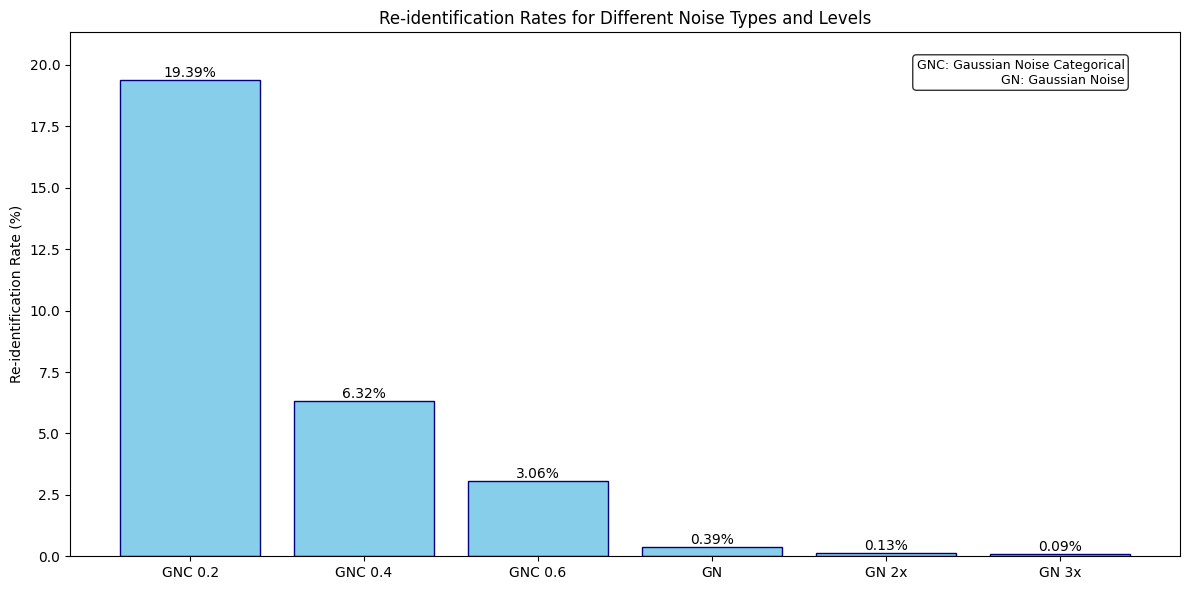

In [55]:
import matplotlib.pyplot as plt

noise_types = ['GNC 0.2', 'GNC 0.4', 'GNC 0.6', 'GN', 'GN 2x', 'GN 3x']
reidentification_rates = [19.39, 6.32, 3.06, 0.39, 0.13, 0.09]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(noise_types, reidentification_rates, color='skyblue', edgecolor='navy')

ax.set_ylabel('Re-identification Rate (%)')
ax.set_title('Re-identification Rates for Different Noise Types and Levels')
ax.set_ylim(0, max(reidentification_rates) * 1.1)  # Set y-axis limit with some padding

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom')


ax.text(0.95, 0.95, 'GNC: Gaussian Noise Categorical\nGN: Gaussian Noise', 
        transform=ax.transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


plt.tight_layout()
plt.show()